# Applying Decoder Lens to Autoformer

In [1]:
import sys

sys.path.append("..")
sys.path.append("../..")
import activations_interpretations.data_utils as data_utils
import analysis.activations_interpretations.CKA as CKA
import analysis.activations_interpretations.activations as activations_file

%matplotlib inline

## 1. Qualitative results

In [2]:
autoformer = data_utils.obtain_autoformer(
    pred_len=96, dataset="seed42_ECL", el=8
)  # n_enclayers = 8

In [3]:
autoformer.encoder.norm

my_Layernorm(
  (layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

In [4]:
import copy
import torch


def encoder_forward_all(encoder, x, attn_mask=None):
    tmp_xs = []  # added by Angela
    attns = []
    if encoder.conv_layers is not None:
        # never here(?)
        for attn_layer, conv_layer in zip(encoder.attn_layers, encoder.conv_layers):
            x, attn = attn_layer(x, attn_mask=attn_mask)
            x = conv_layer(x)
            attns.append(attn)
        x, attn = encoder.attn_layers[-1](x)
        attns.append(attn)
    else:
        for attn_layer in encoder.attn_layers:
            x, attn = attn_layer(x, attn_mask=attn_mask)
            attns.append(attn)
            tmp_xs.append(x)  # added by Angela
            # You might think it is necessary to make a deepcopy of x before appending it to the list,
            # but this is not necessary, as x is a new instance every loop

    if encoder.norm is not None:
        x = encoder.norm(x)

    return x, attns, tmp_xs

In [5]:
import torch


def autoformer_forward_all(
    autoformer,
    x_enc,
    x_mark_enc,
    x_dec,
    x_mark_dec,
    enc_autoformer_mask=None,
    dec_autoformer_mask=None,
    dec_enc_mask=None,
    return_tmpxs=False,
    tmp_layernorm=False,
):

    # decomp init
    mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, autoformer.pred_len, 1)
    zeros = torch.zeros(
        [x_dec.shape[0], autoformer.pred_len, x_dec.shape[2]], device=x_enc.device
    )
    seasonal_init, trend_init = autoformer.decomp(x_enc)
    # decoder input
    trend_init = torch.cat([trend_init[:, -autoformer.label_len :, :], mean], dim=1)
    seasonal_init = torch.cat(
        [seasonal_init[:, -autoformer.label_len :, :], zeros], dim=1
    )
    # enc
    enc_out = autoformer.enc_embedding(x_enc, x_mark_enc)
    # enc_out, attns = autoformer.encoder(enc_out, attn_mask=enc_autoformer_mask)
    enc_out, attns, tmp_xs = encoder_forward_all(
        autoformer.encoder, enc_out, attn_mask=enc_autoformer_mask
    )
    # dec
    dec_out = autoformer.dec_embedding(seasonal_init, x_mark_dec)
    seasonal_part, trend_part = autoformer.decoder(
        dec_out,
        enc_out,
        x_mask=dec_autoformer_mask,
        cross_mask=dec_enc_mask,
        trend=trend_init,
    )
    # final
    dec_out = trend_part + seasonal_part

    tmp_out = []
    for tmp_x in tmp_xs:
        if tmp_layernorm:
            tmp_x = autoformer.encoder.norm(tmp_x)
        tmp_dec_out = autoformer.dec_embedding(seasonal_init, x_mark_dec)
        seasonal_part, trend_part = autoformer.decoder(
            tmp_dec_out,
            tmp_x,
            x_mask=dec_autoformer_mask,
            cross_mask=dec_enc_mask,
            trend=trend_init,
        )
        # final
        tmp_dec_out = trend_part + seasonal_part
        tmp_out.append(tmp_dec_out[:, -autoformer.pred_len :, :])

    if autoformer.output_attention:
        if return_tmpxs:
            return dec_out[:, -autoformer.pred_len :, :], attns, tmp_out, tmp_xs
        else:
            return dec_out[:, -autoformer.pred_len :, :], attns, tmp_out
    else:
        if return_tmpxs:
            return dec_out[:, -autoformer.pred_len :, :], tmp_out, tmp_xs  # [B, L, D]
        else:
            return dec_out[:, -autoformer.pred_len :, :], tmp_out  # [B, L, D]

In [6]:
data_loader = data_utils.obtain_data_loader(pred_len=96, dataset="electricity")

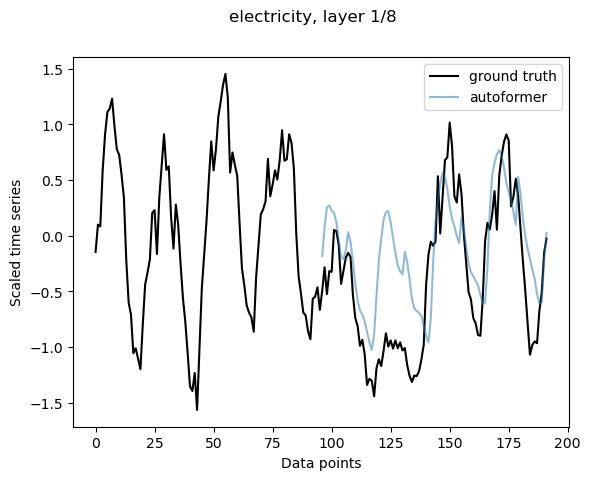

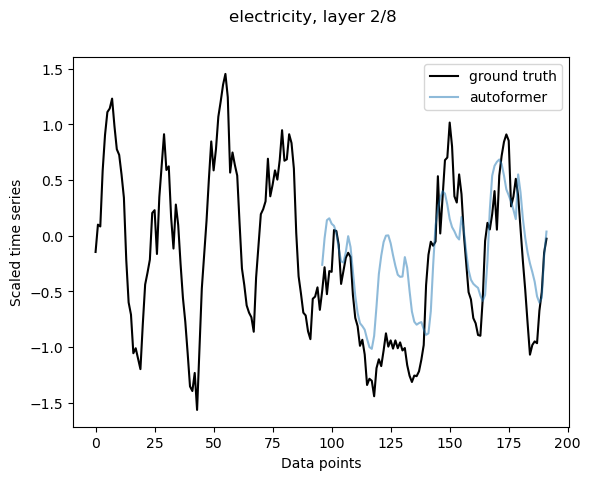

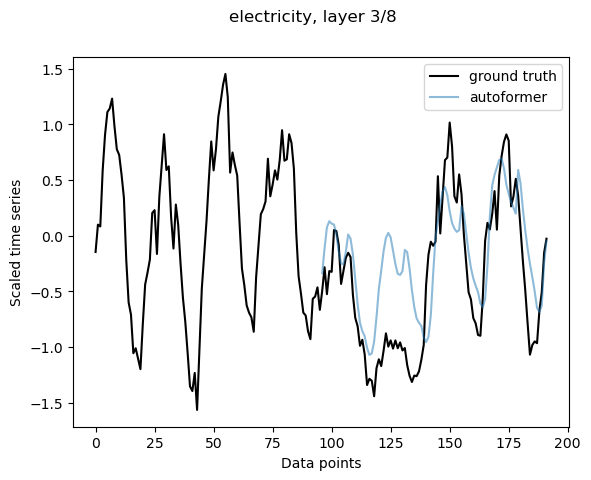

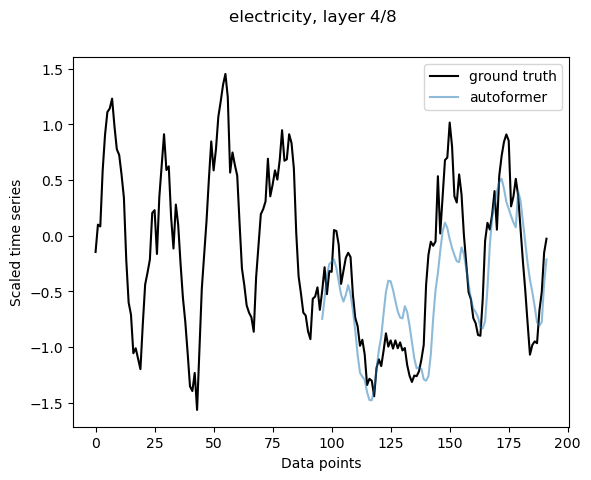

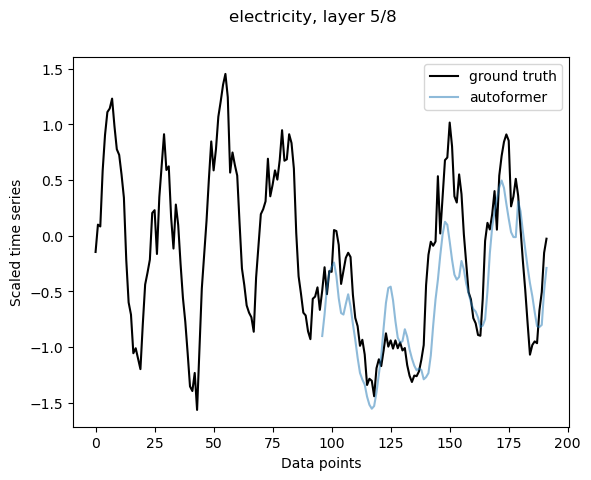

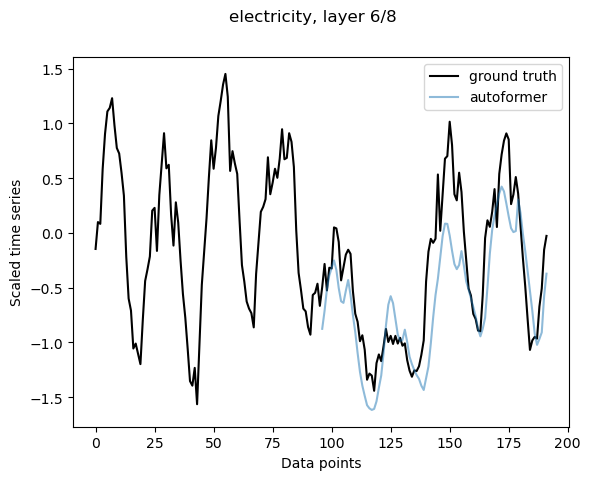

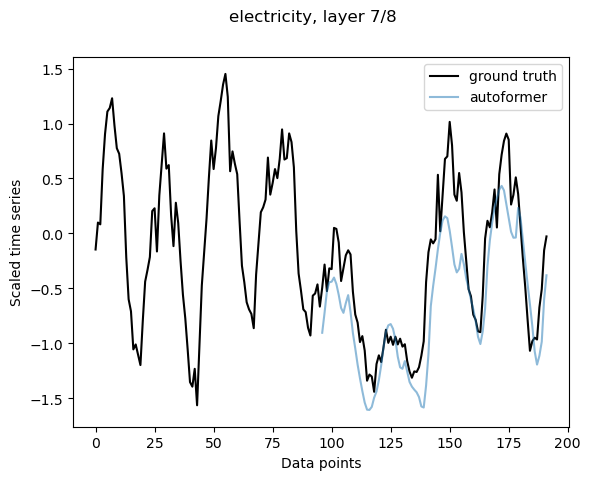

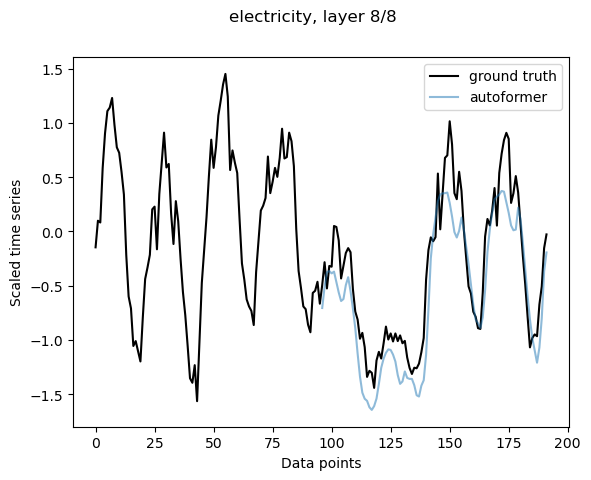

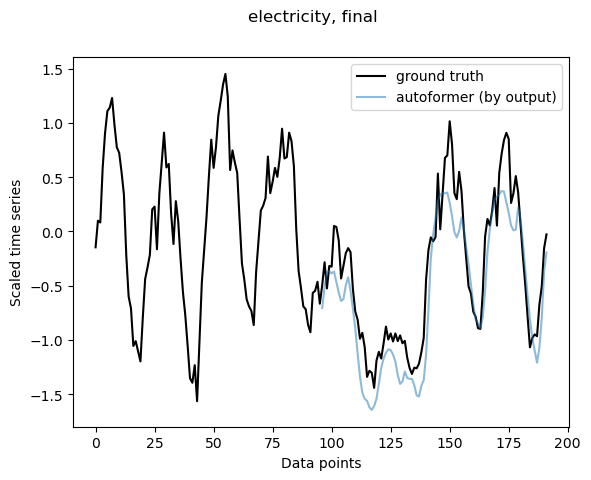

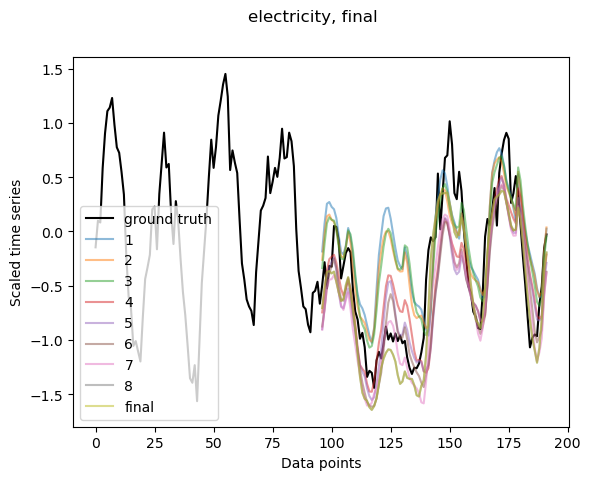

In [32]:
label_len = 48

import numpy as np
import matplotlib.pyplot as plt

alpha_gt = 1
alpha_pred = 0.5
to_save = False
data_set = "electricity"
name_fig = ""

for seq_x, seq_y, seq_x_mark, seq_y_mark in data_loader:
    dec_inp = torch.zeros_like(seq_y[:, -autoformer.pred_len :, :]).float()
    dec_inp = torch.cat([seq_y[:, :label_len, :], dec_inp], dim=1).float()

    gt = np.concatenate((seq_x[0, :, -1], seq_y[0, -autoformer.pred_len :, -1]), axis=0)

    outputs_autoformer, _, all_outputs = autoformer_forward_all(
        autoformer,
        seq_x.float(),
        seq_x_mark.float(),
        dec_inp,
        seq_y_mark.float(),
        tmp_layernorm=True,
    )

    outputs_autoformer = outputs_autoformer.detach().numpy()

    all_preds = {}

    for layer, output in enumerate(all_outputs):
        output = output.detach().numpy()

        pd_autoformer = np.concatenate(
            (
                [np.nan for i in range(seq_x.shape[1])],
                output[0, -autoformer.pred_len :, -1],
            ),
            axis=0,
        )

        all_preds[layer + 1] = pd_autoformer

        plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
        plt.plot(pd_autoformer, label="autoformer", alpha=alpha_pred)

        # for vline in vlines:
        #     plt.axvline(x=vline, color="b", linestyle="--")

        plt.legend()
        plt.xlabel("Data points")
        plt.ylabel("Scaled time series")
        plt.suptitle(f"{data_set}, layer {layer + 1}/{len(all_outputs)}")
        if to_save:
            # plt.savefig(f"plots/{name_plot}.png")
            plt.savefig(name_fig, bbox_inches="tight")
        plt.show()
    pd_autoformer = np.concatenate(
        (
            [np.nan for i in range(seq_x.shape[1])],
            outputs_autoformer[0, -autoformer.pred_len :, -1],
        ),
        axis=0,
    )
    all_preds["final"] = pd_autoformer

    plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
    plt.plot(pd_autoformer, label="autoformer (by output)", alpha=alpha_pred)

    plt.legend()
    plt.xlabel("Data points")
    plt.ylabel("Scaled time series")
    plt.suptitle(f"{data_set}, final")
    if to_save:
        # plt.savefig(f"plots/{name_plot}.png")
        plt.savefig(name_fig, bbox_inches="tight")
    plt.show()

    plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
    for name, pd in all_preds.items():
        plt.plot(pd, label=name, alpha=alpha_pred)

    plt.legend()
    plt.xlabel("Data points")
    plt.ylabel("Scaled time series")
    plt.suptitle(f"{data_set}, final")
    if to_save:
        # plt.savefig(f"plots/{name_plot}.png")
        plt.savefig(name_fig, bbox_inches="tight")
    plt.show()

    break

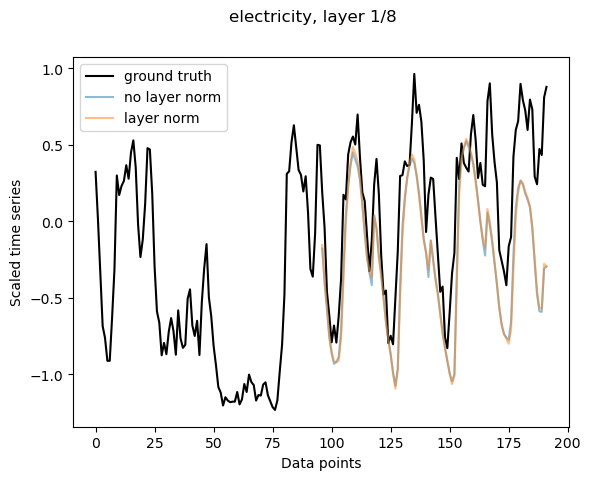

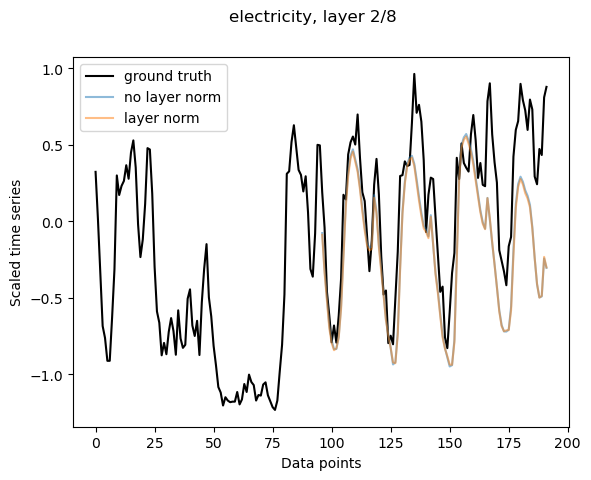

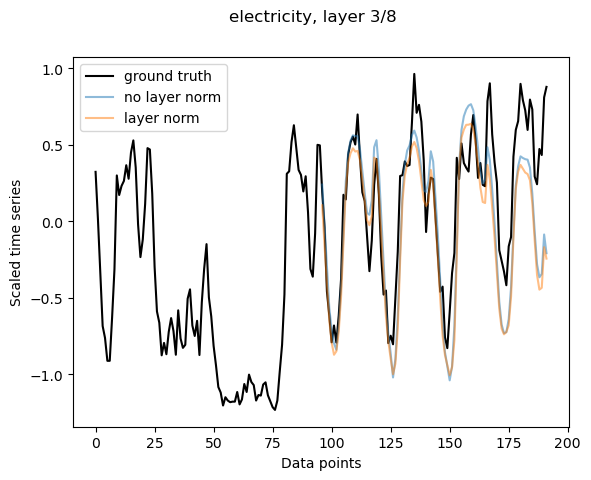

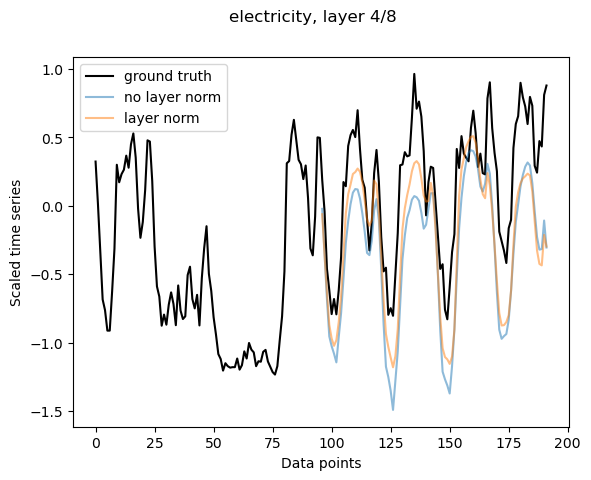

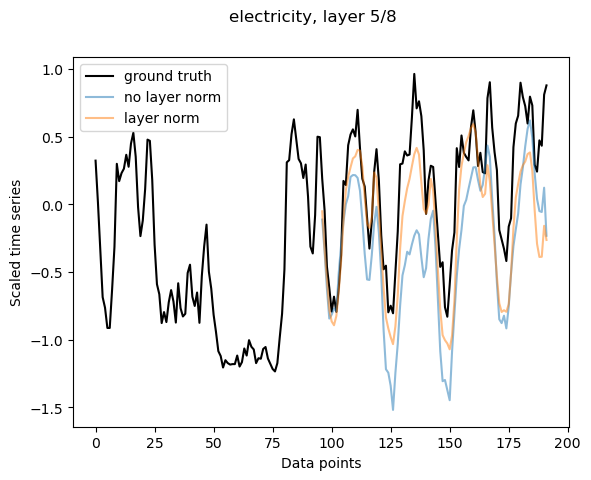

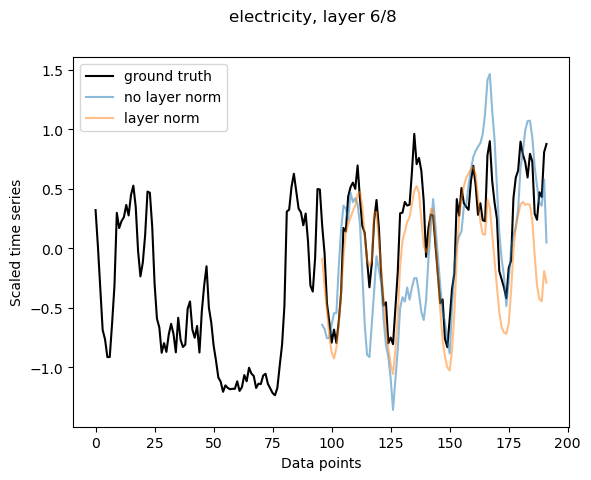

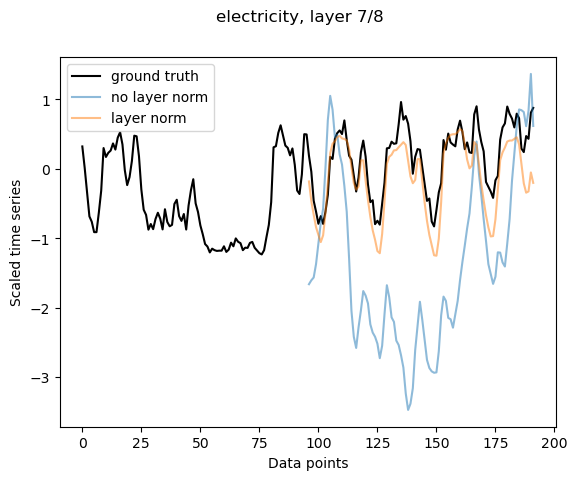

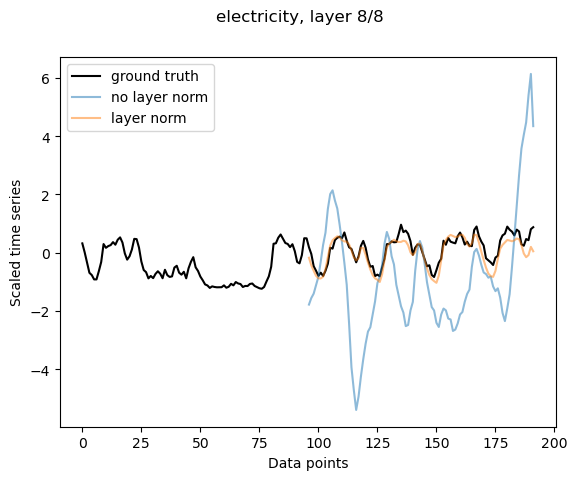

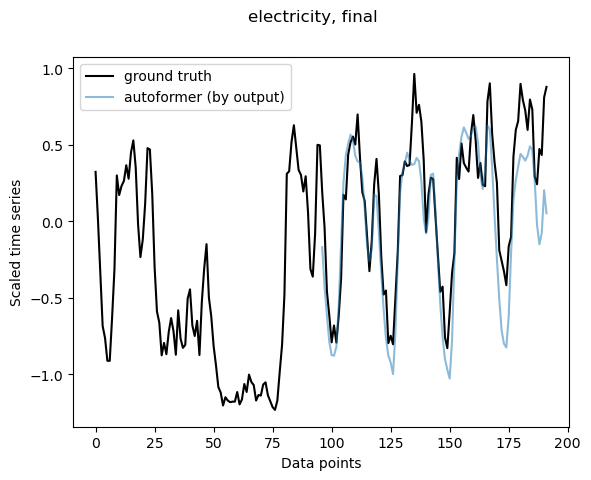

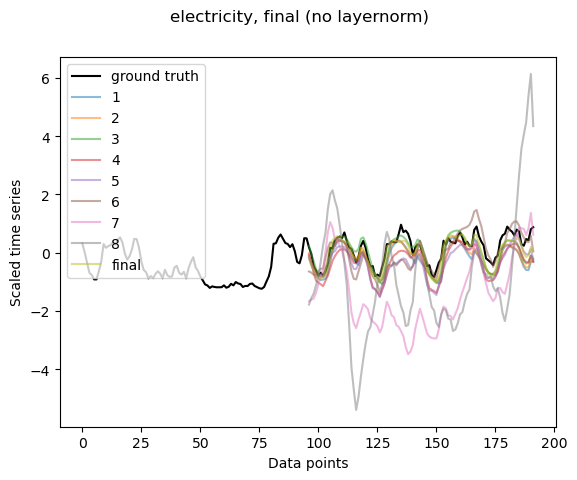

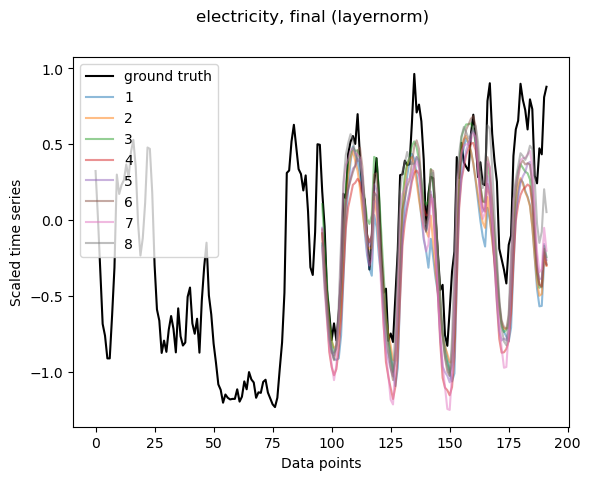

In [8]:
label_len = 48

import numpy as np
import matplotlib.pyplot as plt

alpha_gt = 1
alpha_pred = 0.5
to_save = False
data_set = "electricity"
name_fig = ""

for seq_x, seq_y, seq_x_mark, seq_y_mark in data_loader:
    dec_inp = torch.zeros_like(seq_y[:, -autoformer.pred_len :, :]).float()
    dec_inp = torch.cat([seq_y[:, :label_len, :], dec_inp], dim=1).float()

    gt = np.concatenate((seq_x[0, :, -1], seq_y[0, -autoformer.pred_len :, -1]), axis=0)

    outputs_autoformer, _, all_outputs = autoformer_forward_all(
        autoformer,
        seq_x.float(),
        seq_x_mark.float(),
        dec_inp,
        seq_y_mark.float(),
        tmp_layernorm=False,
    )

    outputs_autoformer_ln, _, all_outputs_ln = autoformer_forward_all(
        autoformer,
        seq_x.float(),
        seq_x_mark.float(),
        dec_inp,
        seq_y_mark.float(),
        tmp_layernorm=True,
    )

    outputs_autoformer = outputs_autoformer.detach().numpy()

    all_preds = {}
    all_preds_ln = {}

    for layer, output in enumerate(all_outputs):
        output = output.detach().numpy()
        output_ln = all_outputs_ln[layer].detach().numpy()

        pd_autoformer = np.concatenate(
            (
                [np.nan for i in range(seq_x.shape[1])],
                output[0, -autoformer.pred_len :, -1],
            ),
            axis=0,
        )
        pd_autoformer_ln = np.concatenate(
            (
                [np.nan for i in range(seq_x.shape[1])],
                output_ln[0, -autoformer.pred_len :, -1],
            ),
            axis=0,
        )

        all_preds[layer + 1] = pd_autoformer
        all_preds_ln[layer + 1] = pd_autoformer_ln

        plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
        plt.plot(pd_autoformer, label="no layer norm", alpha=alpha_pred)
        plt.plot(pd_autoformer_ln, label="layer norm", alpha=alpha_pred)

        # for vline in vlines:
        #     plt.axvline(x=vline, color="b", linestyle="--")

        plt.legend()
        plt.xlabel("Data points")
        plt.ylabel("Scaled time series")
        plt.suptitle(f"{data_set}, layer {layer + 1}/{len(all_outputs)}")
        if to_save:
            # plt.savefig(f"plots/{name_plot}.png")
            plt.savefig(name_fig, bbox_inches="tight")
        plt.show()
    pd_autoformer = np.concatenate(
        (
            [np.nan for i in range(seq_x.shape[1])],
            outputs_autoformer[0, -autoformer.pred_len :, -1],
        ),
        axis=0,
    )
    all_preds["final"] = pd_autoformer

    plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
    plt.plot(pd_autoformer, label="autoformer (by output)", alpha=alpha_pred)

    plt.legend()
    plt.xlabel("Data points")
    plt.ylabel("Scaled time series")
    plt.suptitle(f"{data_set}, final")
    if to_save:
        # plt.savefig(f"plots/{name_plot}.png")
        plt.savefig(name_fig, bbox_inches="tight")
    plt.show()

    plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
    for name, pd in all_preds.items():
        plt.plot(pd, label=name, alpha=alpha_pred)

    plt.legend()
    plt.xlabel("Data points")
    plt.ylabel("Scaled time series")
    plt.suptitle(f"{data_set}, final (no layernorm)")
    if to_save:
        # plt.savefig(f"plots/{name_plot}.png")
        plt.savefig(name_fig, bbox_inches="tight")
    plt.show()

    plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
    for name, pd in all_preds_ln.items():
        plt.plot(pd, label=name, alpha=alpha_pred)

    plt.legend()
    plt.xlabel("Data points")
    plt.ylabel("Scaled time series")
    plt.suptitle(f"{data_set}, final (layernorm)")
    if to_save:
        # plt.savefig(f"plots/{name_plot}.png")
        plt.savefig(name_fig, bbox_inches="tight")
    plt.show()

    break

Note that layer normalization must be done for the output of each intermediate layer, otherwise the forecasts become worse over the layers, as the overall scores increase over the layers. Note that this is also how the method of decoder lens is introduced, to use the final activation layer of the encoder. 

In [14]:
import torch.nn as nn


class my_Layernorm(nn.Module):
    """
    Special designed layernorm for the seasonal part
    """

    def __init__(self, channels):
        super(my_Layernorm, self).__init__()
        self.layernorm = nn.LayerNorm(channels)

    def forward(self, x):
        print(f"x shape: ", x.shape)
        x_hat = self.layernorm(x)
        print(f"x_hat shape: ", x_hat.shape)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        print(
            f"torch.mean(x_hat, dim=1).unsqueeze(1): ",
            torch.mean(x_hat, dim=1).unsqueeze(1).shape,
        )
        print(
            f"torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1): ",
            torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1).shape,
        )
        print(f"bias shape: ", bias.shape)
        return x_hat - bias, x_hat, bias

In [15]:
norm = my_Layernorm(512)

for seq_x, seq_y, seq_x_mark, seq_y_mark in data_loader:
    print(f"seq_x: ", seq_x.shape)
    print(f"seq_y: ", seq_y.shape)
    print(f"seq_x_mark: ", seq_x_mark.shape)
    print(f"seq_y_mark: ", seq_y_mark.shape)

    dec_inp = torch.zeros_like(seq_y[:, -autoformer.pred_len :, :]).float()
    dec_inp = torch.cat([seq_y[:, :label_len, :], dec_inp], dim=1).float()

    gt = np.concatenate((seq_x[0, :, -1], seq_y[0, -autoformer.pred_len :, -1]), axis=0)

    print(f"dec_inp: ", dec_inp.shape)
    outputs_autoformer, _, all_outputs, tmp_xs = autoformer_forward_all(
        autoformer,
        seq_x.float(),
        seq_x_mark.float(),
        dec_inp,
        seq_y_mark.float(),
        return_tmpxs=True,
    )
    break

seq_x:  torch.Size([1, 96, 321])
seq_y:  torch.Size([1, 144, 321])
seq_x_mark:  torch.Size([1, 96, 4])
seq_y_mark:  torch.Size([1, 144, 4])
dec_inp:  torch.Size([1, 144, 321])


## 2. Quantitative results

In [9]:
from collections import defaultdict
from utils.metrics import metric


def test(model, test_loader):

    all_preds = defaultdict(list)
    trues = []
    # folder_path = './test_results/' + setting + '/'
    # if not os.path.exists(folder_path):
    #     os.makedirs(folder_path)

    model.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
            batch_x = batch_x.float()
            batch_y = batch_y.float()

            batch_x_mark = batch_x_mark.float()
            batch_y_mark = batch_y_mark.float()

            dec_inp = torch.zeros_like(seq_y[:, -autoformer.pred_len :, :]).float()
            dec_inp = torch.cat([seq_y[:, :label_len, :], dec_inp], dim=1).float()

            outputs_autoformer, _, all_outputs = autoformer_forward_all(
                autoformer,
                batch_x.float(),
                batch_x_mark.float(),
                dec_inp,
                batch_y_mark.float(),
                tmp_layernorm=True,
            )
            # outputs, batch_y = self._predict(batch_x, batch_y, batch_x_mark, batch_y_mark)

            true = batch_y[:, -autoformer.pred_len :, :]
            # pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
            # true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()

            for layer, tmp_out in enumerate(all_outputs):
                all_preds[layer].append(tmp_out)

            trues.append(true)

            print(f"true[0, :, -1]: ", true[0, :, -1].shape)
            print(f"tmp_out[0, :, -1]: ", tmp_out[0, :, -1].shape)
            if i % 20 == 0:
                input = batch_x.detach().cpu().numpy()
                gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
                for layer, tmp_out in enumerate(all_outputs):
                    pd = np.concatenate(
                        ([np.nan for i in range(batch_x.shape[1])], tmp_out[0, :, -1]),
                        axis=0,
                    )
                    plt.plot(pd, label=f"prediction {layer+1}/{len(all_outputs)}")
                plt.plot(gt, label="ground truth")
                plt.legend()
                plt.show()
                # visual(gt, pd, os.path.join(folder_path, str(i) + '.pdf'))

    print(all_preds.keys())
    print(max(all_preds.keys()))
    max_layer = max(all_preds.keys())
    for layer in all_preds.keys():
        all_preds[layer] = np.concatenate(all_preds[layer], axis=0)
    trues = np.concatenate(trues, axis=0)
    print("test shape:", all_preds[max_layer].shape, trues.shape)
    for layer in all_preds.keys():
        all_preds[layer] = all_preds[layer].reshape(
            -1, all_preds[layer].shape[-2], all_preds[layer].shape[-1]
        )
    trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
    print("test shape:", all_preds[max_layer].shape, trues.shape)

    # # result save
    # folder_path = './results/' + setting + '/'
    # if not os.path.exists(folder_path):
    #     os.makedirs(folder_path)

    metrics = {}
    metrics["mae"] = {}
    metrics["mse"] = {}
    metrics["rmse"] = {}
    metrics["mape"] = {}
    metrics["mspe"] = {}
    metrics["mase"] = {}

    for layer, preds in all_preds.items():
        mae, mse, rmse, mape, mspe, mase = metric(preds, trues)
        metrics["mae"][layer] = mae
        metrics["mse"][layer] = mse
        metrics["rmse"][layer] = rmse
        metrics["mape"][layer] = mape
        metrics["mspe"][layer] = mspe
        metrics["mase"][layer] = mase

    return metrics

In [10]:
autoformer.output_attention
test_loader = data_utils.obtain_data_loader(
    pred_len=96, dataset="electricity", split="test"
)

In [11]:
# metrics = test(autoformer, test_loader)

In [18]:
import numpy as np

path = "../results/"
name = "seed42_ECL_96_96_Autoformer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el8_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/metrics.npy"

metrics = np.load(path + name, allow_pickle=True)

In [19]:
metrics = metrics.item()

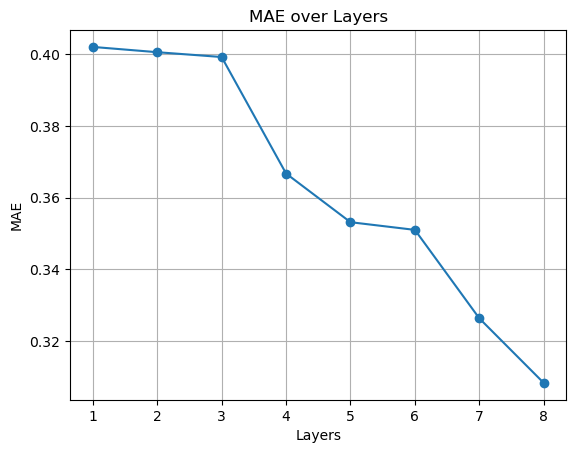

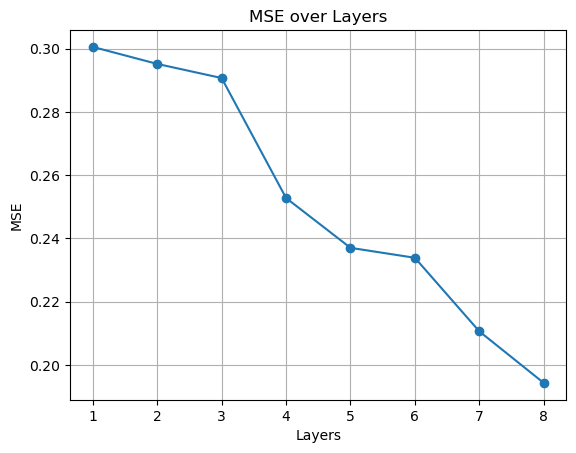

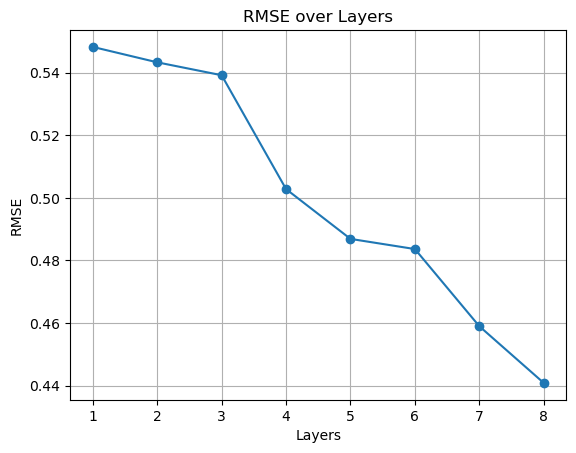

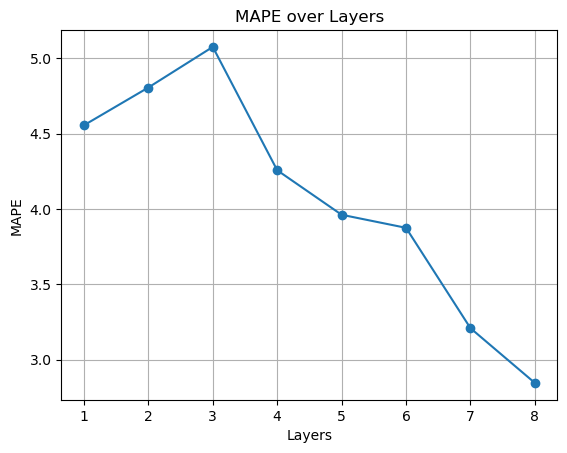

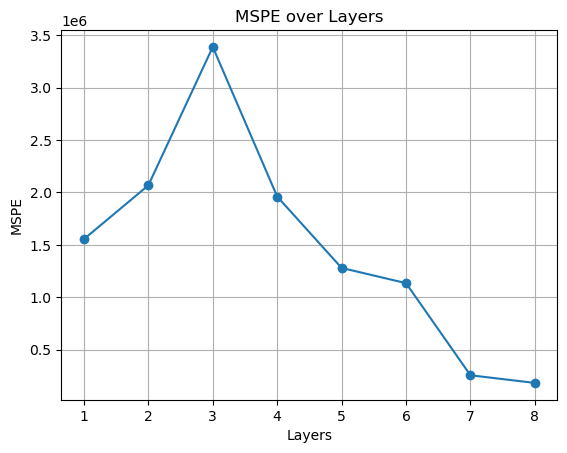

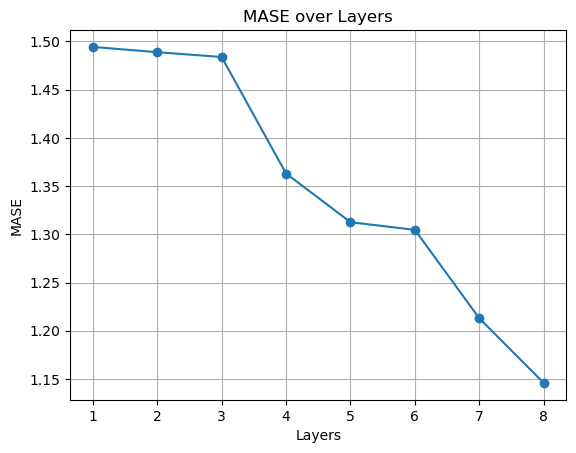

In [27]:
import matplotlib.pyplot as plt

# Plot each metric
for metric_name, values in metrics.items():
    plt.figure()
    plt.plot([i + 1 for i in list(values.keys())], list(values.values()), marker="o")
    plt.title(f"{metric_name.upper()} over Layers")
    plt.xlabel("Layers")
    plt.ylabel(metric_name.upper())
    plt.grid(True)
    plt.show()

## 3. Qualitative Results for Non-Standard Cases

In [13]:
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt

autoformer = data_utils.obtain_autoformer(
    pred_len=96, dataset="seed42_ECL", el=8
)  # n_enclayers = 8

data_loader = data_utils.obtain_data_loader(
    pred_len=96, dataset="electricity", split="test"
)
label_len = 48

In [34]:
def encoder_forward_all(encoder, x, attn_mask=None):
    tmp_xs = []  # added by Angela
    attns = []
    if encoder.conv_layers is not None:
        # never here(?)
        for attn_layer, conv_layer in zip(encoder.attn_layers, encoder.conv_layers):
            x, attn = attn_layer(x, attn_mask=attn_mask)
            x = conv_layer(x)
            attns.append(attn)
        x, attn = encoder.attn_layers[-1](x)
        attns.append(attn)
    else:
        for attn_layer in encoder.attn_layers:
            x, attn = attn_layer(x, attn_mask=attn_mask)
            attns.append(attn)
            tmp_xs.append(x)  # added by Angela
            # You might think it is necessary to make a deepcopy of x before appending it to the list,
            # but this is not necessary, as x is a new instance every loop

    if encoder.norm is not None:
        x = encoder.norm(x)

    return x, attns, tmp_xs


def autoformer_forward_all(
    autoformer,
    x_enc,
    x_mark_enc,
    x_dec,
    x_mark_dec,
    enc_autoformer_mask=None,
    dec_autoformer_mask=None,
    dec_enc_mask=None,
    return_tmpxs=False,
    tmp_layernorm=False,
):

    # decomp init
    mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, autoformer.pred_len, 1)
    zeros = torch.zeros(
        [x_dec.shape[0], autoformer.pred_len, x_dec.shape[2]], device=x_enc.device
    )
    seasonal_init, trend_init = autoformer.decomp(x_enc)
    # decoder input
    trend_init = torch.cat([trend_init[:, -autoformer.label_len :, :], mean], dim=1)
    seasonal_init = torch.cat(
        [seasonal_init[:, -autoformer.label_len :, :], zeros], dim=1
    )
    # enc
    enc_out = autoformer.enc_embedding(x_enc, x_mark_enc)
    # enc_out, attns = autoformer.encoder(enc_out, attn_mask=enc_autoformer_mask)
    enc_out, attns, tmp_xs = encoder_forward_all(
        autoformer.encoder, enc_out, attn_mask=enc_autoformer_mask
    )
    # dec
    dec_out = autoformer.dec_embedding(seasonal_init, x_mark_dec)
    seasonal_part, trend_part = autoformer.decoder(
        dec_out,
        enc_out,
        x_mask=dec_autoformer_mask,
        cross_mask=dec_enc_mask,
        trend=trend_init,
    )
    # final
    dec_out = trend_part + seasonal_part

    tmp_out = []
    for tmp_x in tmp_xs:
        if tmp_layernorm:
            tmp_x = autoformer.encoder.norm(tmp_x)
        tmp_dec_out = autoformer.dec_embedding(seasonal_init, x_mark_dec)
        seasonal_part, trend_part = autoformer.decoder(
            tmp_dec_out,
            tmp_x,
            x_mask=dec_autoformer_mask,
            cross_mask=dec_enc_mask,
            trend=trend_init,
        )
        # final
        tmp_dec_out = trend_part + seasonal_part
        tmp_out.append(tmp_dec_out[:, -autoformer.pred_len :, :])

    if autoformer.output_attention:
        if return_tmpxs:
            return dec_out[:, -autoformer.pred_len :, :], attns, tmp_out, tmp_xs
        else:
            return dec_out[:, -autoformer.pred_len :, :], attns, tmp_out
    else:
        if return_tmpxs:
            return dec_out[:, -autoformer.pred_len :, :], tmp_out, tmp_xs  # [B, L, D]
        else:
            return dec_out[:, -autoformer.pred_len :, :], tmp_out  # [B, L, D]


def get_enc_dec_input(dataloader, model):
    for seq_x, seq_y, seq_x_mark, seq_y_mark in dataloader:
        dec_inp = torch.zeros_like(seq_y[:, -model.pred_len :, :]).float()

        dec_inp = torch.cat([seq_y[:, :label_len, :], dec_inp], dim=1).float()
        gt = np.concatenate((seq_x[0, :, -1], seq_y[0, -model.pred_len :, -1]), axis=0)
        return seq_x, seq_y, seq_x_mark, seq_y_mark, dec_inp, gt


def get_enc_dec_input_altered(dataloader, model, zero_data=False, zero_timestamp=False):
    for seq_x, seq_y, seq_x_mark, seq_y_mark in dataloader:
        dec_inp = torch.zeros_like(seq_y[:, -model.pred_len :, :]).float()

        if zero_data:
            dec_inp_zero = torch.cat(
                [dec_inp[:, :label_len, :], dec_inp], dim=1
            ).float()
            dec_inp = torch.cat([seq_y[:, :label_len, :], dec_inp], dim=1).float()
            seq_x_zero = torch.zeros_like(seq_x)
            gt = np.concatenate(
                (seq_x_zero[0, :, -1], seq_y[0, -model.pred_len :, -1]), axis=0
            )

            return (
                seq_x_zero,
                seq_x,
                seq_y,
                seq_x_mark,
                seq_y_mark,
                dec_inp_zero,
                dec_inp,
                gt,
            )


def plot_decoder_lens_results(
    dataloader,
    model,
    zero_data=False,
    zero_timestamp=False,
    alpha_gt=1,
    alpha_pred=0.5,
    to_save=False,
    data_set="electricity",
    name_fig="",
):

    if zero_data or zero_timestamp:
        (
            seq_x_altered,
            seq_x,
            seq_y,
            seq_x_mark,
            seq_y_mark,
            dec_inp_altered,
            dec_inp,
            gt,
        ) = get_enc_dec_input_altered(dataloader, model, zero_data, zero_timestamp)

        outputs_autoformer_altered, _, all_outputs_altered = autoformer_forward_all(
            model,
            seq_x_altered.float(),
            seq_x_mark.float(),
            dec_inp_altered,
            seq_y_mark.float(),
            tmp_layernorm=True,
        )

        outputs_autoformer_altered = outputs_autoformer_altered.detach().numpy()

        all_preds_altered = {}
    else:
        seq_x, seq_y, seq_x_mark, seq_y_mark, dec_inp, gt = get_enc_dec_input(
            dataloader, model
        )

    outputs_autoformer, _, all_outputs = autoformer_forward_all(
        model,
        seq_x.float(),
        seq_x_mark.float(),
        dec_inp,
        seq_y_mark.float(),
        tmp_layernorm=True,
    )

    outputs_autoformer = outputs_autoformer.detach().numpy()

    all_preds = {}

    for layer, output in enumerate(all_outputs):
        output = output.detach().numpy()

        pd_autoformer = np.concatenate(
            (
                [np.nan for i in range(seq_x.shape[1])],
                output[0, -model.pred_len :, -1],
            ),
            axis=0,
        )
        all_preds[layer + 1] = pd_autoformer

        if zero_data or zero_timestamp:
            print(all_outputs_altered[layer].shape)
            output_altered = all_outputs_altered[layer].detach().numpy()
            pd_autoformer_altered = np.concatenate(
                (
                    [np.nan for i in range(seq_x.shape[1])],
                    output_altered[0, -model.pred_len :, -1],
                ),
                axis=0,
            )
            all_preds_altered[layer + 1] = pd_autoformer_altered

        plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
        plt.plot(pd_autoformer, label="autoformer", alpha=alpha_pred)

        if zero_data:
            plt.plot(pd_autoformer_altered, label="zero data", alpha=alpha_pred)

        # for vline in vlines:
        #     plt.axvline(x=vline, color="b", linestyle="--")

        plt.legend()
        plt.xlabel("Data points")
        plt.ylabel("Scaled time series")
        plt.suptitle(f"{data_set}, layer {layer + 1}/{len(all_outputs)}")
        if to_save:
            # plt.savefig(f"plots/{name_plot}.png")
            plt.savefig(name_fig, bbox_inches="tight")
        plt.show()
    pd_autoformer = np.concatenate(
        (
            [np.nan for i in range(seq_x.shape[1])],
            outputs_autoformer[0, -model.pred_len :, -1],
        ),
        axis=0,
    )
    all_preds["final"] = pd_autoformer

    plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
    plt.plot(pd_autoformer, label="autoformer (by output)", alpha=alpha_pred)

    plt.legend()
    plt.xlabel("Data points")
    plt.ylabel("Scaled time series")
    plt.suptitle(f"{data_set}, final")
    if to_save:
        # plt.savefig(f"plots/{name_plot}.png")
        plt.savefig(name_fig, bbox_inches="tight")
    plt.show()

    plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
    for name, pd in all_preds.items():
        plt.plot(pd, label=name, alpha=alpha_pred)

    plt.legend()
    plt.xlabel("Data points")
    plt.ylabel("Scaled time series")
    plt.suptitle(f"{data_set}, final")
    if to_save:
        # plt.savefig(f"plots/{name_plot}.png")
        plt.savefig(name_fig, bbox_inches="tight")
    plt.show()

    if zero_data:
        plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
        for name, pd in all_preds_altered.items():
            plt.plot(pd, label=name, alpha=alpha_pred)

        plt.legend()
        plt.xlabel("Data points")
        plt.ylabel("Scaled time series")
        plt.suptitle(f"{data_set}, zero data")
        if to_save:
            # plt.savefig(f"plots/{name_plot}.png")
            plt.savefig(name_fig, bbox_inches="tight")
        plt.show()

torch.Size([1, 96, 321])


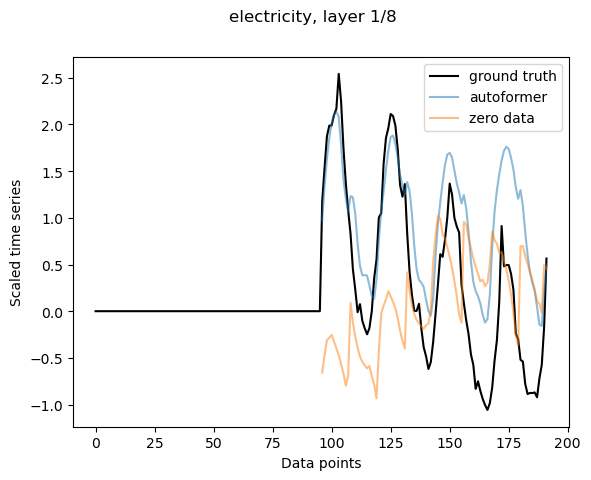

torch.Size([1, 96, 321])


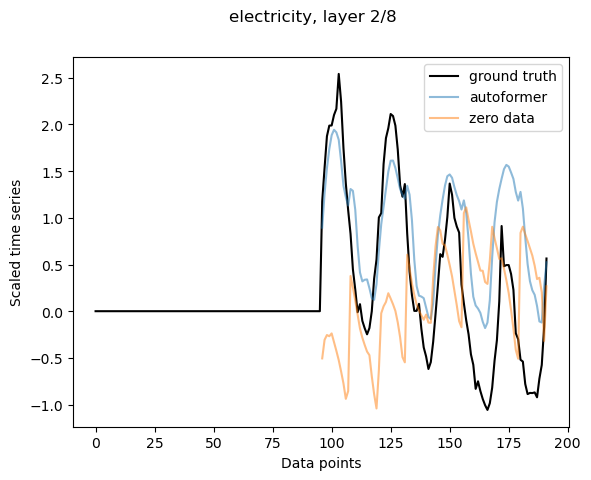

torch.Size([1, 96, 321])


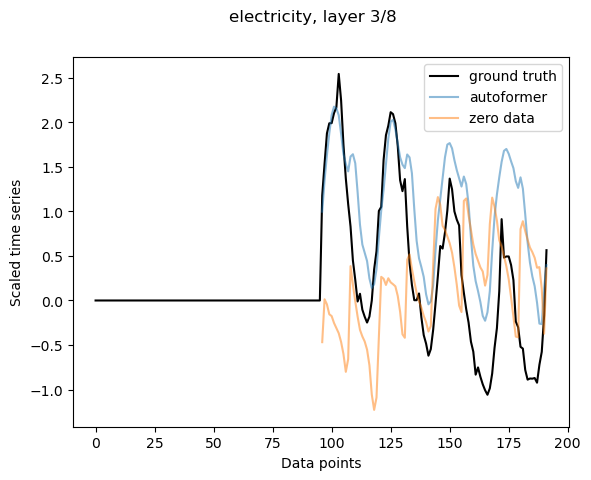

torch.Size([1, 96, 321])


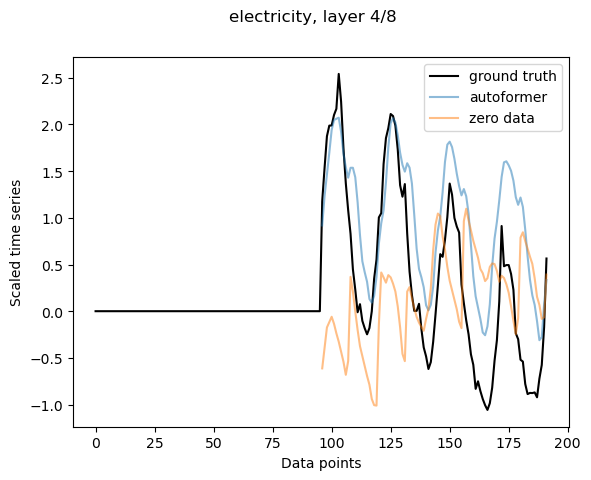

torch.Size([1, 96, 321])


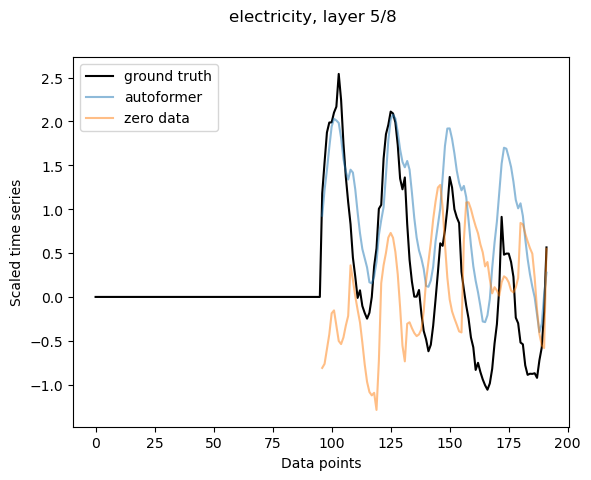

torch.Size([1, 96, 321])


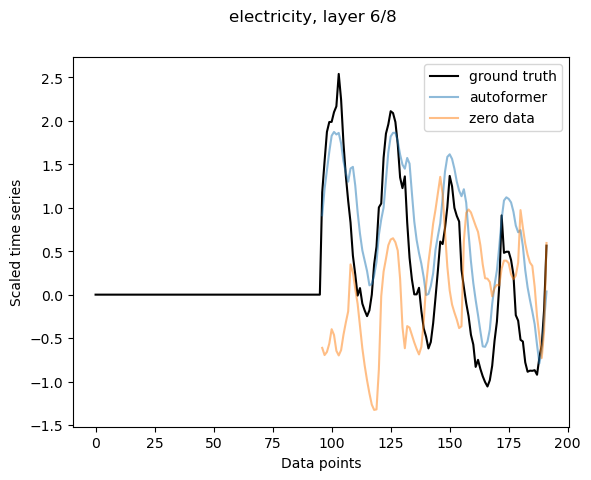

torch.Size([1, 96, 321])


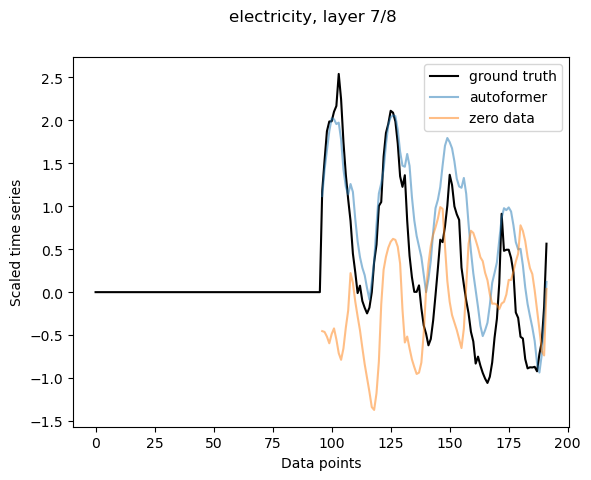

torch.Size([1, 96, 321])


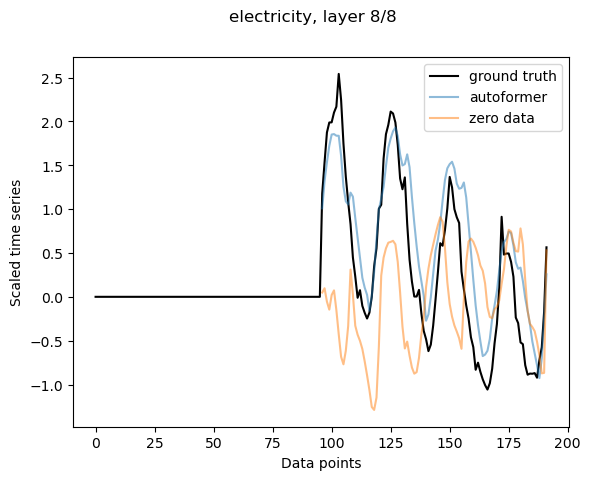

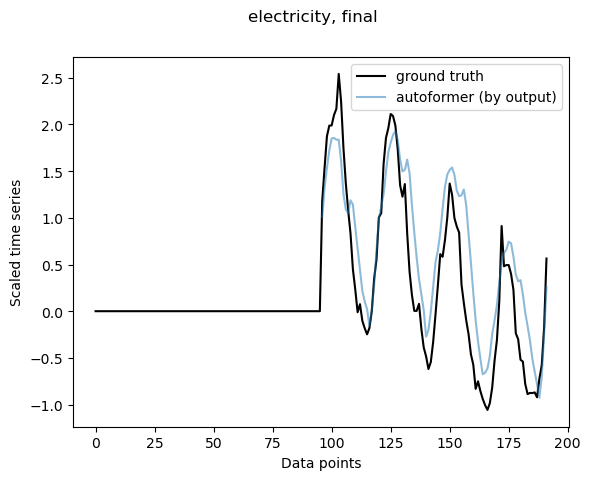

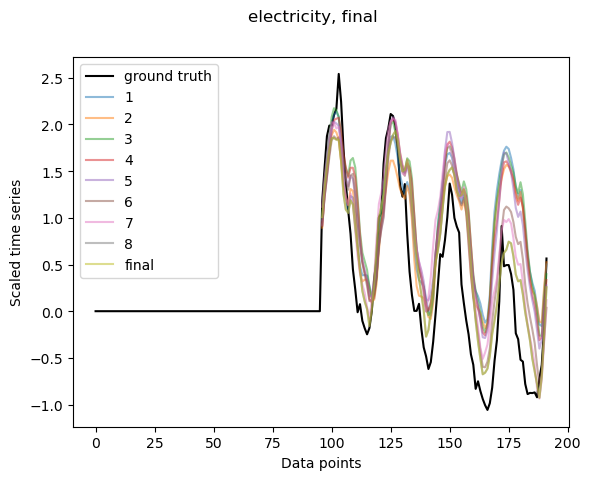

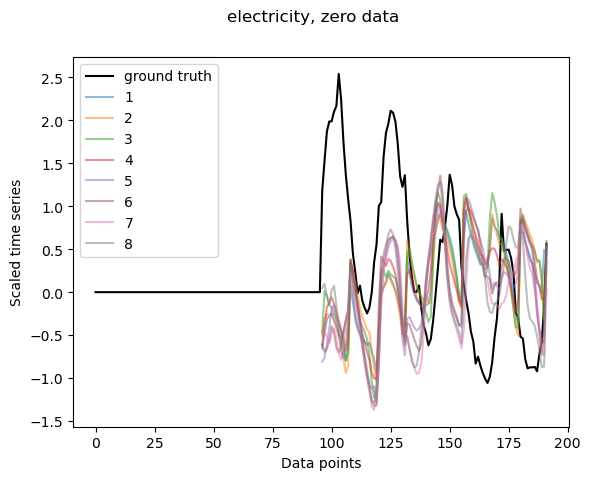

In [35]:
all_outputs_altered = plot_decoder_lens_results(data_loader, autoformer, zero_data=True)

In [22]:
seq_x_altered, seq_x, seq_y, seq_x_mark, seq_y_mark, dec_inp_altered, dec_inp, gt = (
    get_enc_dec_input_altered(data_loader, autoformer, zero_data=True)
)

outputs_autoformer_altered, _, all_outputs_altered = autoformer_forward_all(
    autoformer,
    seq_x_altered.float(),
    seq_x_mark.float(),
    dec_inp_altered,
    seq_y_mark.float(),
    tmp_layernorm=True,
)

In [29]:
len(all_outputs_altered)
all_outputs_altered[0].shape
all_outputs_altered[1].shape
all_outputs_altered[2].shape

torch.Size([1, 96, 321])

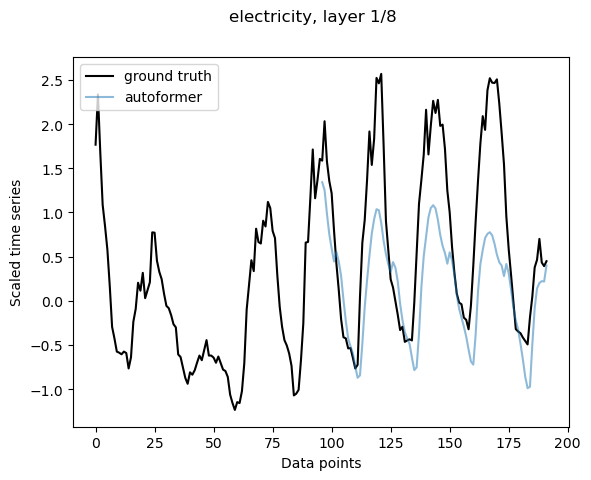

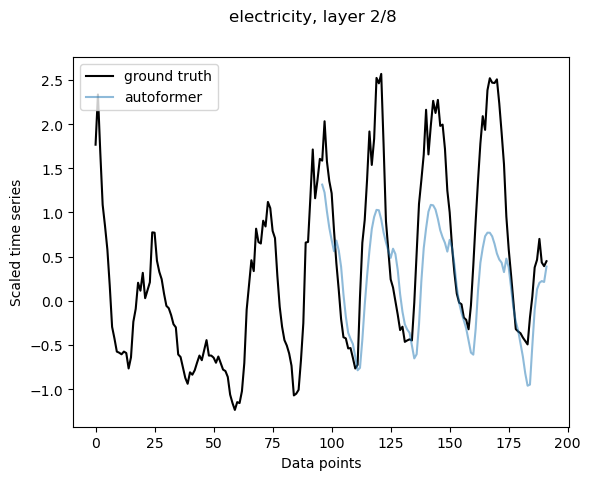

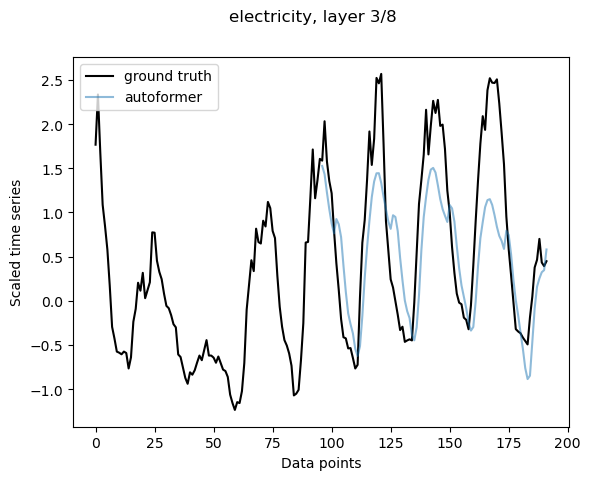

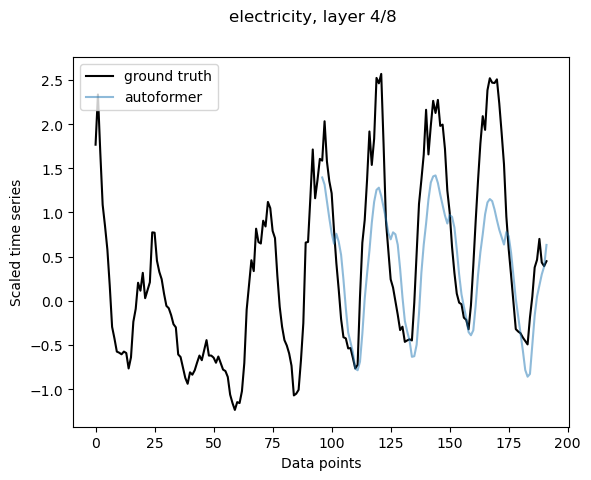

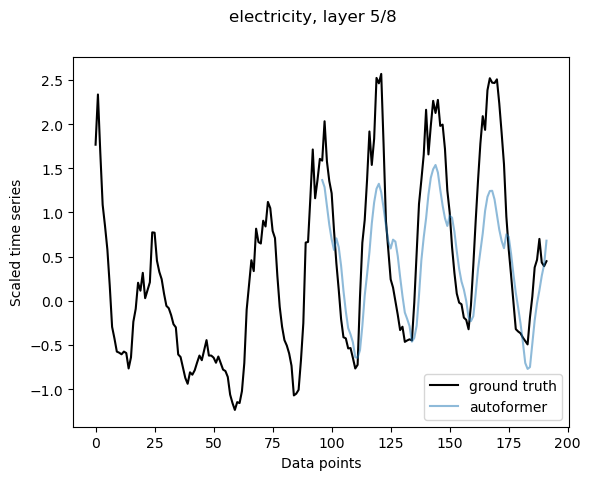

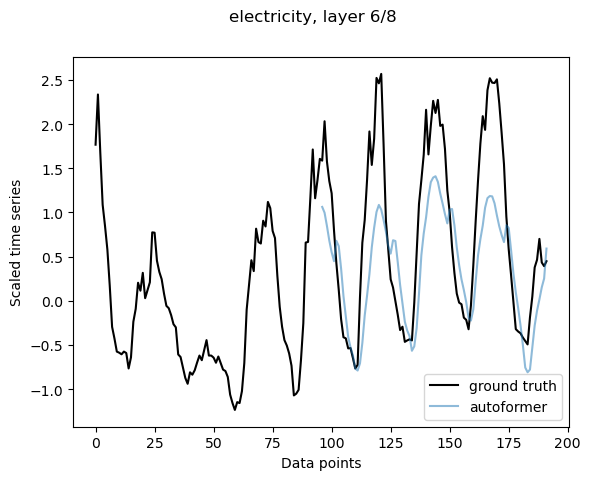

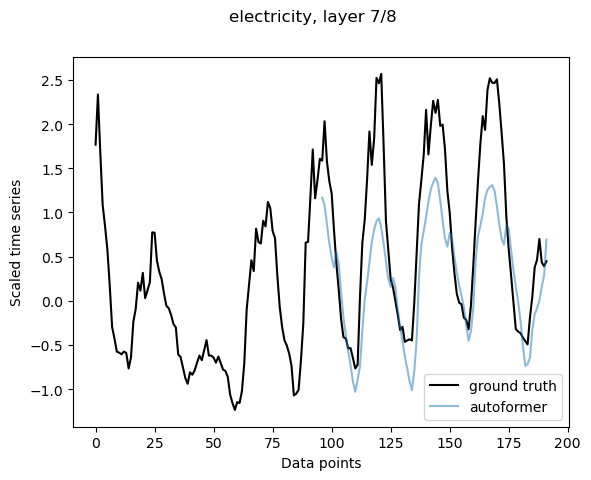

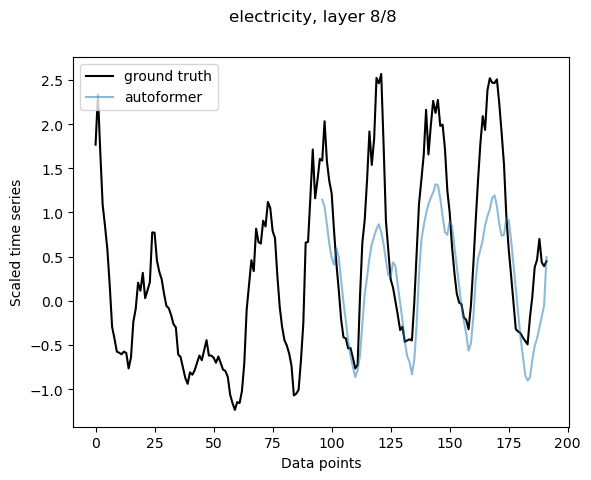

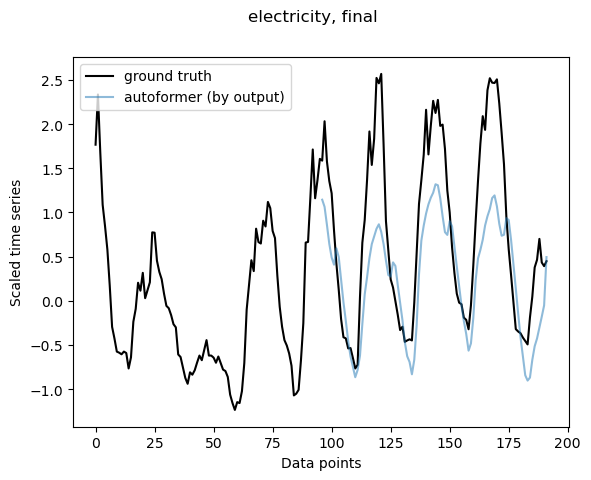

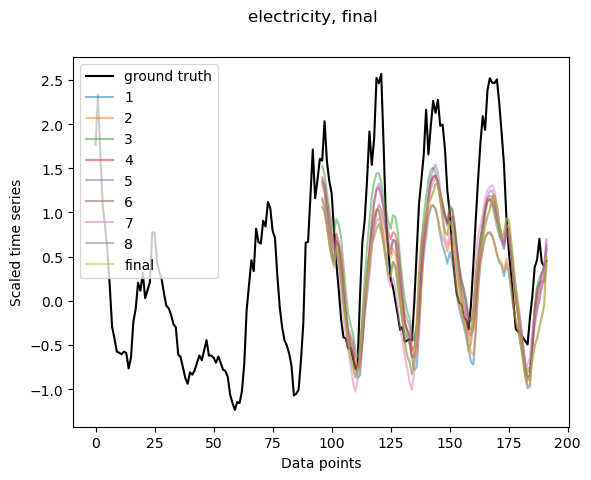

In [15]:
plot_decoder_lens_results(data_loader, autoformer, zero_data=False)